In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
from pathlib import Path
import pandas as pd
import pickle
import numpy as np
import torch
from torch import utils
import pandas as pd
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torch import nn 
from torch.nn import functional as F
import pytorch_lightning as pl
from matplotlib import cm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from scipy import signal as sig
import os
from pathlib import Path
import re
from torch.utils import data
import random
import pandas as pd
import pickle
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

import cv2 as cv
from landmarks_video import LandmarksVideo
from triplets_gui import Animation, ClipsDisplay, VerificationApp
import landmarks_video
import triplets_gui

In [4]:
from deep_cluster.simple_autoencoder import Autoencoder, PLAutoencoder
from deep_cluster import dataloader
seqlen = 60
data_root = Path('/home/orel/Storage/Data/K7')
landmark_files = list(data_root.glob('2020-*/Down/*DeepCut*.h5'))
to_drop = ['head', 'forepawR2', 'forePawL2', 'chest1', 'chest2', 'belly1', 'belly2', 'hindpawR2', 
           'hindpawR3', 'hindpawL2', 'hindpawL3', 'tail1', 'tail2','tail3']
dm = dataloader.LandmarksDataModule(landmark_files, step=1, seqlen=seqlen, to_drop=None)
dm.prepare_data()


array([[<AxesSubplot:title={'center':'nose'}>,
        <AxesSubplot:title={'center':'head'}>,
        <AxesSubplot:title={'center':'forepawR1'}>,
        <AxesSubplot:title={'center':'forepawR2'}>],
       [<AxesSubplot:title={'center':'forePawL1'}>,
        <AxesSubplot:title={'center':'forePawL2'}>,
        <AxesSubplot:title={'center':'chest1'}>,
        <AxesSubplot:title={'center':'chest2'}>],
       [<AxesSubplot:title={'center':'belly1'}>,
        <AxesSubplot:title={'center':'belly2'}>,
        <AxesSubplot:title={'center':'hindpawR1'}>,
        <AxesSubplot:title={'center':'hindpawR2'}>],
       [<AxesSubplot:title={'center':'hindpawR3'}>,
        <AxesSubplot:title={'center':'hindpawL1'}>,
        <AxesSubplot:title={'center':'hindpawL2'}>,
        <AxesSubplot:title={'center':'hindpawL3'}>],
       [<AxesSubplot:title={'center':'tailbase'}>,
        <AxesSubplot:title={'center':'tail1'}>,
        <AxesSubplot:title={'center':'tail2'}>,
        <AxesSubplot:title={'center':'t

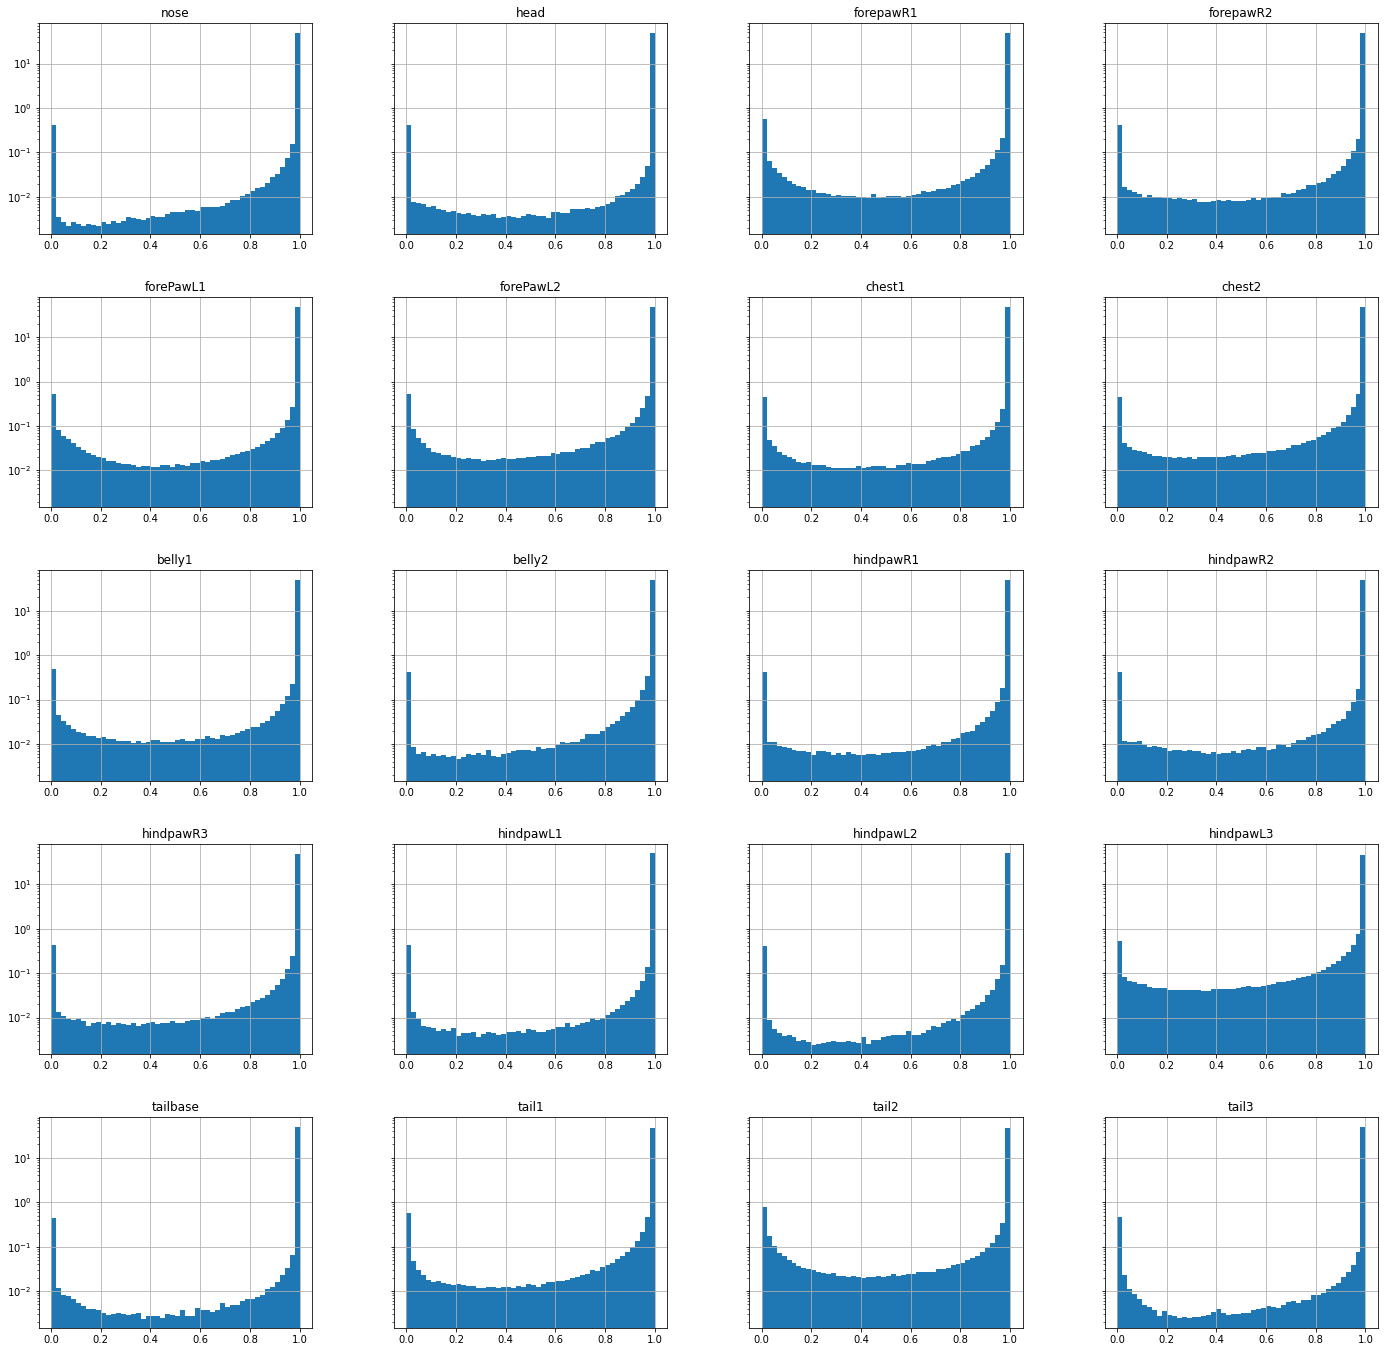

In [5]:
dm.all_df.xs('likelihood', axis=1, level=1).hist(figsize=(24, 24), log=True, sharey=True, bins=50, density=True)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 6)) 
tail_parts = ['tail1', 'tail2', 'tail3']
shoulder_parts = ['forepawR1', 'forePawL1', 'hindpawR1', 'hindpawL1']
np.prod(dm.all_df.xs('likelihood', axis=1, level=1) > 0.95, axis=1)\
        .hist(bins=10, log=False, ax=axes[0])
np.prod(dm.all_df.drop(labels=tail_parts, axis=1, level=0).xs('likelihood', axis=1, level=1) > 0.95, axis=1)\
        .hist(bins=10, log=False, ax=axes[1])
axes[0].set_title('all')
axes[1].set_title('no tail')

In [ ]:
def segment_confidence(segment_df):
    confidence = np.prod(segment_df.xs('likelihood', level=1, axis=1, drop_level=True) > 0.95, axis=1)
    return confidence.mean()

def segment_energy(segment_df):
    data = segment_df.drop('likelihood', level=1, axis=1).values.astype(np.float32)
    ff, Pxx = sig.periodogram(data.T, fs=120)
    energy = Pxx[:,:10].mean()
    return energy

def filter_segment(segment_df):
    return filter_by_likelihood(segment_df) and filter_by_energy(segment_df)

df = dm.all_df.iloc[:200000]
seqlen, step = 60, 20
energies, confidences = [], []
# filtered_by_energy, filtered_by_likelihood = [], []
for start in range(0, len(df), step):
    segment_df = df.iloc[start: start + seqlen]
    segment_df = segment_df.drop(tail_parts + shoulder_parts + ['nose'], axis=1, level=0)
    energies.append(segment_energy(segment_df))
    confidences.append(segment_confidence(segment_df))
#     filtered.append(filter_segment(segment_df))

energies, confidences = np.array(energies), np.array(confidences)

filtered_by_energy, filtered_by_likelihood = energies > 1e0, confidences > 0.95
filtered = np.logical_and(filtered_by_energy, filtered_by_likelihood)
filtered.mean()